### 📘 02_preprocessing.ipynb – Imputación y tratamiento de valores atípicos

Este notebook contiene el preprocesamiento del dataset de diabetes, incluyendo:

- Reemplazo de valores no válidos.
- Imputación de valores faltantes.
- Detección visual de outliers.
- Exportación del dataset limpio para uso posterior.

#### 1. Carga del dataset y configuración de librerías

Importamos las librerías necesarias y visualizamos las primeras filas del conjunto de datos.


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

# Estilo gráfico
sns.set(style="whitegrid")
%matplotlib inline

# Cargar el dataset limpio desde la ruta relativa
df = pd.read_csv("../data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 2. Detección de valores inválidos (ceros) y reemplazos de valores faltantes

Algunas variables biométricas no pueden tener valores igual a cero. A continuación identificamos cuántos ceros hay en las columnas críticas.
Reemplazamos los ceros por `NaN` para poder imputarlos posteriormente.


In [91]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ver cuántos ceros hay en cada una
df[columns_with_zeros].eq(0).sum()

df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
df.isnull().sum()


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### 3. Imputación de valores faltantes usando mediana

La mediana es preferida porque es robusta ante valores extremos (outliers).


In [92]:
df[columns_with_zeros] = df[columns_with_zeros].fillna(df[columns_with_zeros].median())
df.isnull().sum()

# Verificar si los valores han sido reemplazados correctamente
df[columns_with_zeros].eq(0).sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

### 4. Visualización de posibles valores atípicos (outliers)

Usamos boxplots para detectar visualmente si existen valores atípicos en las variables.


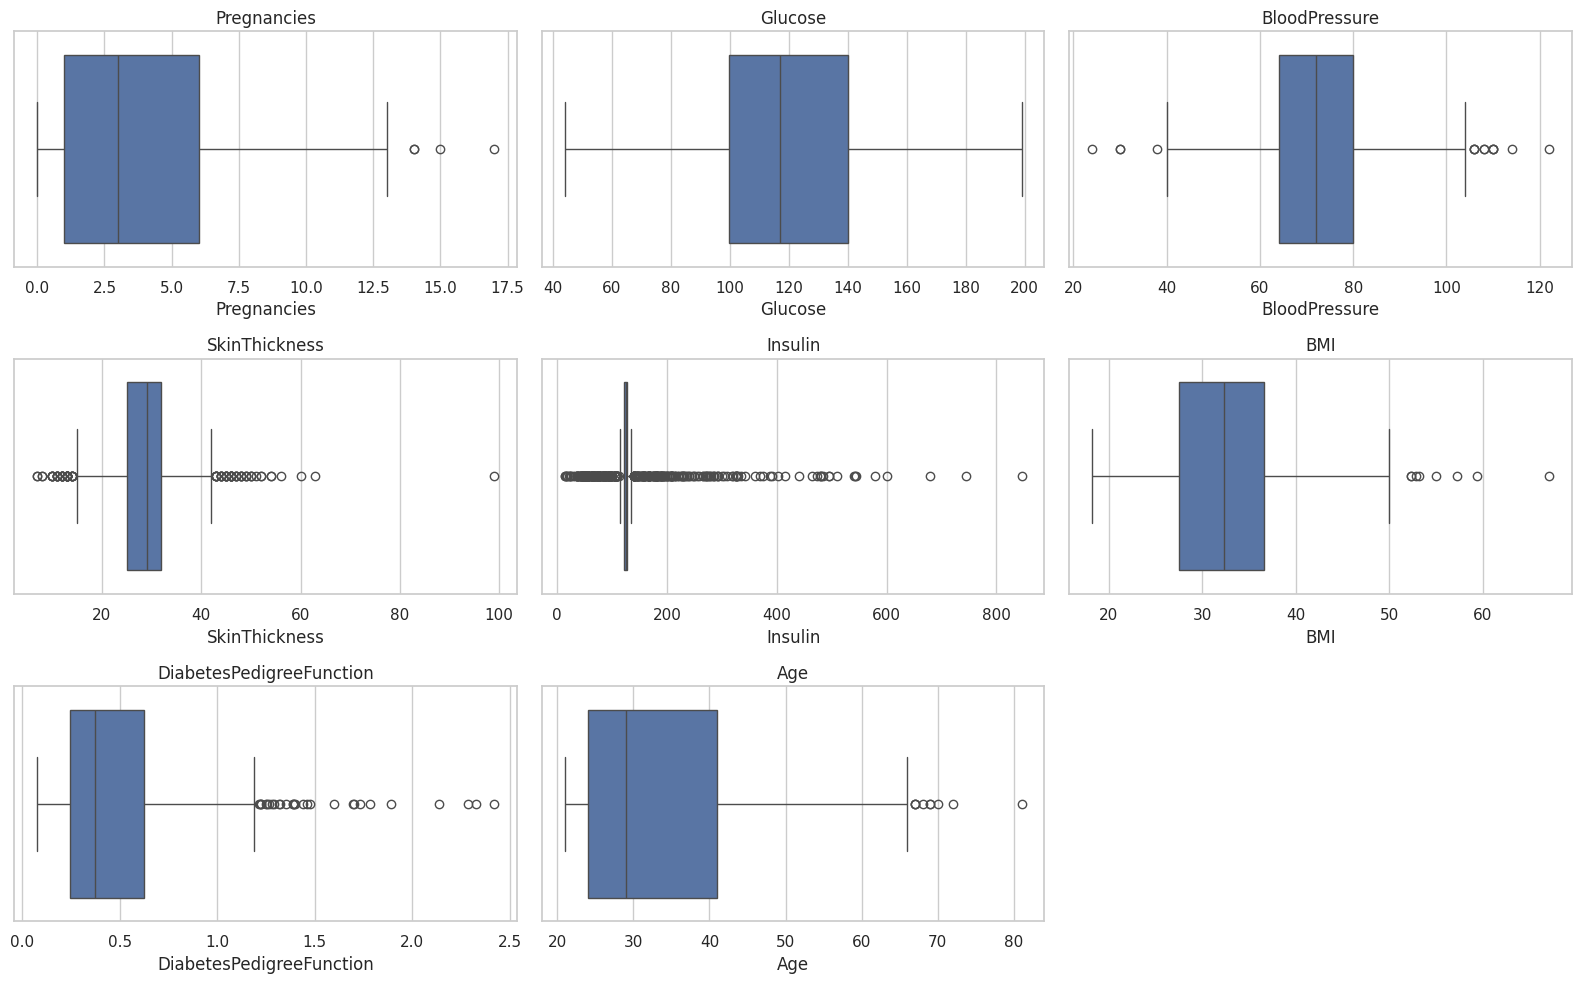

In [93]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


🎯 Tratamiento de outliers: Capping por percentiles

Durante el análisis exploratorio, se detectaron valores extremos (outliers) en algunas variables numéricas, como `Insulin` y `SkinThickness`, con valores muy superiores al rango típico de la población.

Se decidió aplicar **capping** por percentiles (también llamado recorte), que consiste en limitar los valores extremos a los percentiles 1% y 99%. Esta técnica presenta las siguientes ventajas en este caso:

- 🔹 **Preserva el tamaño del dataset**, lo cual es importante dado que solo se cuenta con 768 registros.
- 🔹 **Evita que los valores extremos sesguen el entrenamiento** de modelos sensibles como regresión logística o SVM.
- 🔹 **Es menos agresiva que eliminar datos**, lo que permite conservar patrones valiosos.

Las variables seleccionadas para capping fueron aquellas con mayor presencia de outliers detectados previamente.


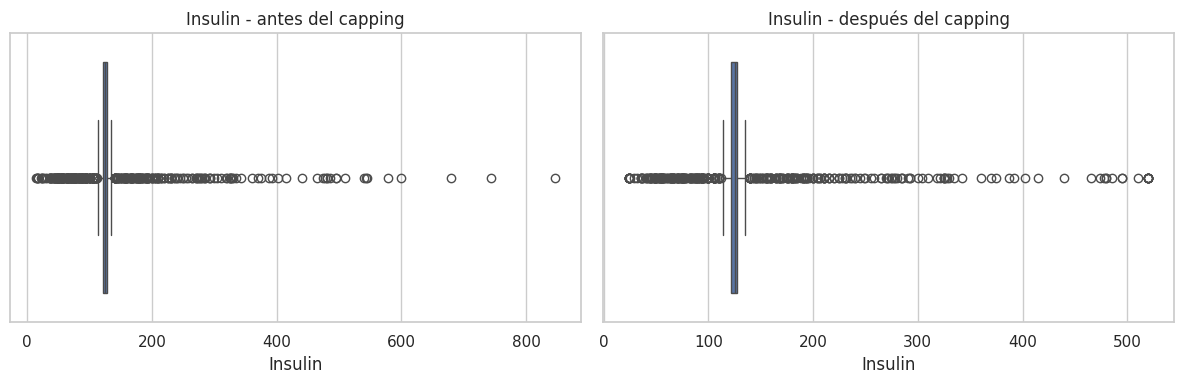

In [94]:
# Aplicación de capping (recorte) en variables con outliers

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['Insulin'], ax=axes[0])
axes[0].set_title("Insulin - antes del capping")

cols_to_cap = ['Insulin', 'SkinThickness', 'BloodPressure', 'BMI']

for col in cols_to_cap:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=q_low, upper=q_high)

sns.boxplot(x=df['Insulin'], ax=axes[1])
axes[1].set_title("Insulin - después del capping")
plt.tight_layout()
plt.show()

🧪 Efecto del capping en la variable `Insulin`

Como se observa en el boxplot, la aplicación de capping entre los percentiles 1% y 99% redujo notablemente la influencia de los valores atípicos extremos sin eliminar registros. Esto mejora la robustez de los modelos al tiempo que se conserva la información general del dataset.

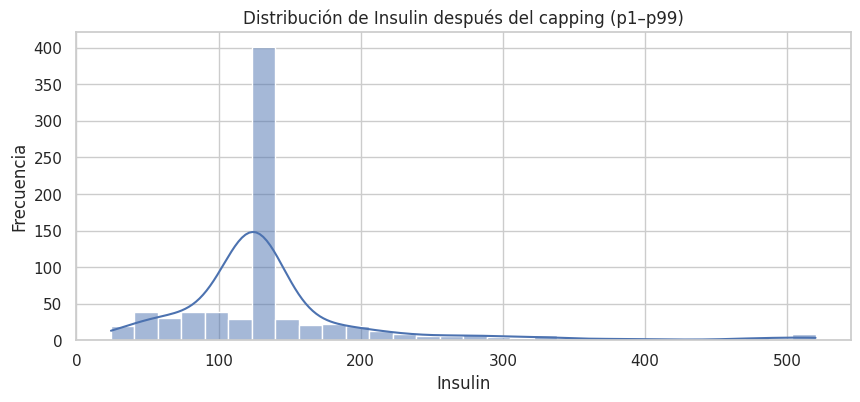

In [95]:
plt.figure(figsize=(10,4))
sns.histplot(df['Insulin'], bins=30, kde=True)
plt.title("Distribución de Insulin después del capping (p1–p99)")
plt.xlabel("Insulin")
plt.ylabel("Frecuencia")
plt.show()

🔁 Transformación de variables con alta asimetría

Algunas variables presentan una distribución altamente asimétrica, lo que puede afectar el desempeño de ciertos modelos sensibles a la escala y distribución. Usamos la métrica de skewness para identificar estas variables.

Transformamos las siguientes variables con `np.log1p(x)`:
- `Insulin`: skew = 2.67
- `DiabetesPedigreeFunction`: skew = 1.92

`log1p` es ideal para manejar valores cercanos a cero sin generar errores (log(0) es indefinido).


In [96]:
# Calcular skewness de todas las variables numéricas (excepto la variable objetivo)
skew_values = df.drop(columns='Outcome').skew().sort_values(ascending=False)
print(skew_values)

Insulin                     2.669974
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Pregnancies                 0.901674
Glucose                     0.535587
BMI                         0.375596
BloodPressure               0.189482
SkinThickness               0.150672
dtype: float64


In [97]:
df['Insulin'] = np.log1p(df['Insulin'])
df['DiabetesPedigreeFunction'] = np.log1p(df['DiabetesPedigreeFunction'])


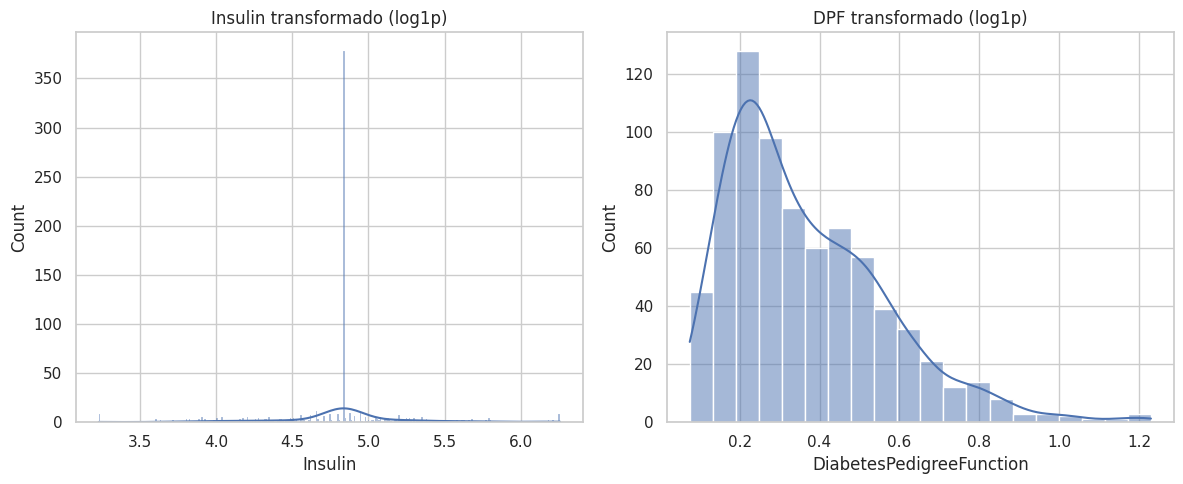

In [98]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Insulin'], kde=True, ax=axes[0])
axes[0].set_title('Insulin transformado (log1p)')
sns.histplot(df['DiabetesPedigreeFunction'], kde=True, ax=axes[1])
axes[1].set_title('DPF transformado (log1p)')
plt.tight_layout()
plt.show()

In [99]:
print(df[['Insulin', 'DiabetesPedigreeFunction']].skew())

Insulin                    -0.086189
DiabetesPedigreeFunction    1.117942
dtype: float64


Decidimos **no aplicar transformaciones adicionales** a la variable `DiabetesPedigreeFunction` ya que:

- La transformación logarítmica redujo su asimetría de ~1.92 a ~1.11.
- Esta asimetría es considerada aceptable para muchos modelos, especialmente aquellos que no se ven muy afectados por distribuciones no normales.


ℹ️ Nota sobre escalado y selección de características

El análisis de `mutual_info_classif` se aplica **antes del escalado de datos**.  
Esto se debe a que la **mutua información** mide dependencia estadística entre variables y **no se ve afectada por la escala** de los datos.  
Escalar variables no altera la cantidad de información que aportan sobre la variable objetivo.

Por lo tanto:

- Primero imputamos y realizamos capping de valores extremos
- Luego aplicamos `mutual_info_classif` para evaluar la importancia relativa de cada feature
- Finalmente, si se requiere, aplicamos `StandardScaler` en el pipeline de entrenamiento

Esta secuencia evita problemas de interpretación y mejora la robustez del análisis.

In [100]:
# Separar características y variable objetivo
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

Ganancia de información mutua por feature:
Glucose                     0.117009
BMI                         0.086795
Age                         0.083335
Pregnancies                 0.038087
Insulin                     0.022465
DiabetesPedigreeFunction    0.015970
SkinThickness               0.014824
BloodPressure               0.000636
dtype: float64


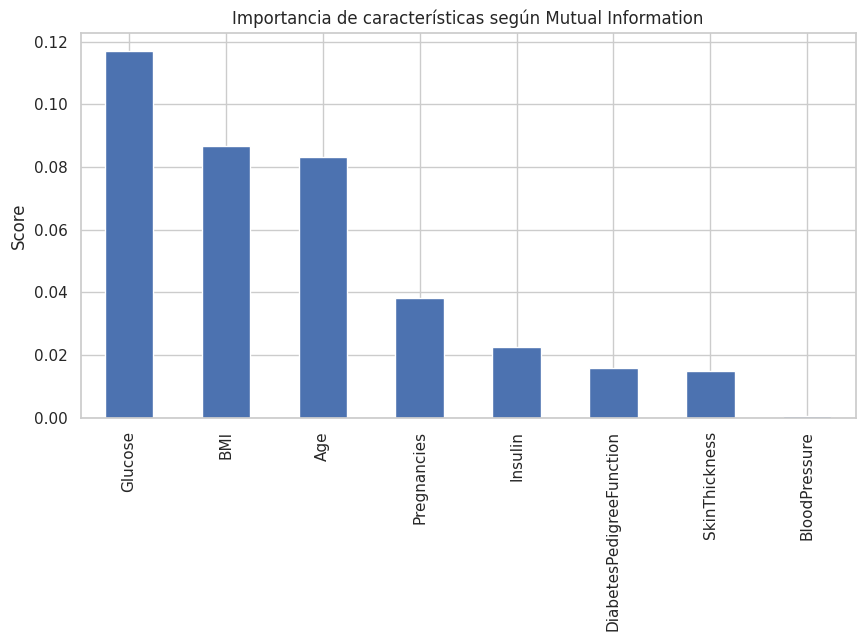

In [101]:
mutual_info = mutual_info_classif(X, y)
mi_series = pd.Series(mutual_info, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print("Ganancia de información mutua por feature:")
print(mi_series)

plt.figure(figsize=(10,5))
mi_series.plot(kind='bar')
plt.title('Importancia de características según Mutual Information')
plt.ylabel('Score')
plt.show()

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

import os

os.makedirs("../data/features", exist_ok=True)

X_train.to_csv("../data/features/X_train.csv", index=False)
X_test.to_csv("../data/features/X_test.csv", index=False)
y_train.to_csv("../data/features/y_train.csv", index=False)
y_test.to_csv("../data/features/y_test.csv", index=False)

print("✅ Datasets guardados en carpeta: data/features/")

✅ Datasets guardados en carpeta: data/features/


### ✅ 📌 Conclusión del Preprocesamiento

- Se identificaron y reemplazaron valores fisiológicamente imposibles (ceros en variables clínicas) como valores faltantes (`NaN`).
- Se aplicó **imputación con la mediana** para asegurar un tratamiento robusto ante valores extremos.
- Se realizó **capping** por percentiles para reducir el impacto de outliers severos, especialmente en variables como `Insulin`.
- Se aplicó **transformación logarítmica** a variables con alta asimetría (`Insulin`, `DiabetesPedigreeFunction`) para reducir su sesgo.
- Se realizó un análisis de **importancia de características** mediante `mutual_info_classif`, lo cual permitió identificar que `Glucose`, `BMI` y `Age` aportan mayor información al modelo.
- Aún no se ha realizado escalado, ya que dependerá del tipo de modelo seleccionado posteriormente. Para modelos basados en distancia (SVM, KNN), se aplicará `StandardScaler` en el siguiente notebook.
- Finalmente, los datos fueron divididos en conjuntos de entrenamiento y prueba, y guardados en archivos `.csv` en la carpeta `data/features/` para su uso posterior en el pipeline de entrenamiento.
